Kết nối với Google Drive


Khai báo các thư viện cần thiết

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Khai báo đường dẫn để lấy dữ liệu

In [2]:
train_images_path = 'data/train-images-idx3-ubyte.gz'
train_labels_path = 'data/train-labels-idx1-ubyte.gz'
test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'
test_images_path = 'data/t10k-images-idx3-ubyte.gz'

Xây dựng hàm đọc dữ liệu từ file 

In [3]:
def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
  """
  This shuffle param is active when .gz is downloaded at:
  - 'http://yann.lecun.com/exdb/mnist/'
  - This function return random num_images in 60000 or 10000
  """
  # read data
  import gzip # to decompress gz (zip) file
  # open file training to read training data
  f_images = gzip.open(images_path,'r')
  # skip 16 first bytes because these are not data, only header infor
  f_images.read(16)
  # general: read num_images data samples if this parameter is set;
  # if not, read all (60000 training or 10000 test)
  real_num = num_images if not shuffle else (60000 if _is else 10000)
  # read all data to buf_images (28x28xreal_num)
  buf_images = f_images.read(image_size * image_size * real_num)
  # images
  images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
  images = images.reshape(real_num, image_size, image_size,)
  # Read labels
  f_labels = gzip.open(labels_path,'r')
  f_labels.read(8)

  labels = np.zeros((real_num)).astype(np.int64)
  # rearrange to correspond the images and labels
  for i in range(0, real_num):
    buf_labels = f_labels.read(1)
    labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    
    # shuffle to get random images data
  if shuffle is True:
    rand_id = np.random.randint(real_num, size=num_images)
    images = images[rand_id, :]
    labels = labels[rand_id,]
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
  return images, labels

Lấy dữ liệu và chia tập dữ liệu

In [4]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 60000, shuffle=True)
test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


Ta muốn có 3 tập dữ liệu, train, validation and test. Vậy nên ta sẽ gộp 2 bộ train và test ban đầu lại và tách thành 3 bộ

In [5]:
# Combine train and test data
all_images = np.concatenate([train_images, test_images], axis=0)
all_labels = np.concatenate([train_labels, test_labels], axis=0)

# Shuffle combined data
np.random.seed(42)
shuffle_idx = np.random.permutation(len(all_images))
all_images = all_images[shuffle_idx]
all_labels = all_labels[shuffle_idx]

# Split into train, test, and validation sets
train_split = 0.8
val_split = 0.1
test_split = 0.1

num_examples = len(all_images)
num_train = int(train_split * num_examples)
num_val = int(val_split * num_examples)

train_images = all_images[:num_train]
train_labels = all_labels[:num_train]

val_images = all_images[num_train:num_train+num_val]
val_labels = all_labels[num_train:num_train+num_val]

test_images = all_images[num_train+num_val:]
test_labels = all_labels[num_train+num_val:]

print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape, test_labels.shape)


(56000, 784) (56000,)
(7000, 784) (7000,)
(7000, 784) (7000,)


Hiển thị một số ví dụ

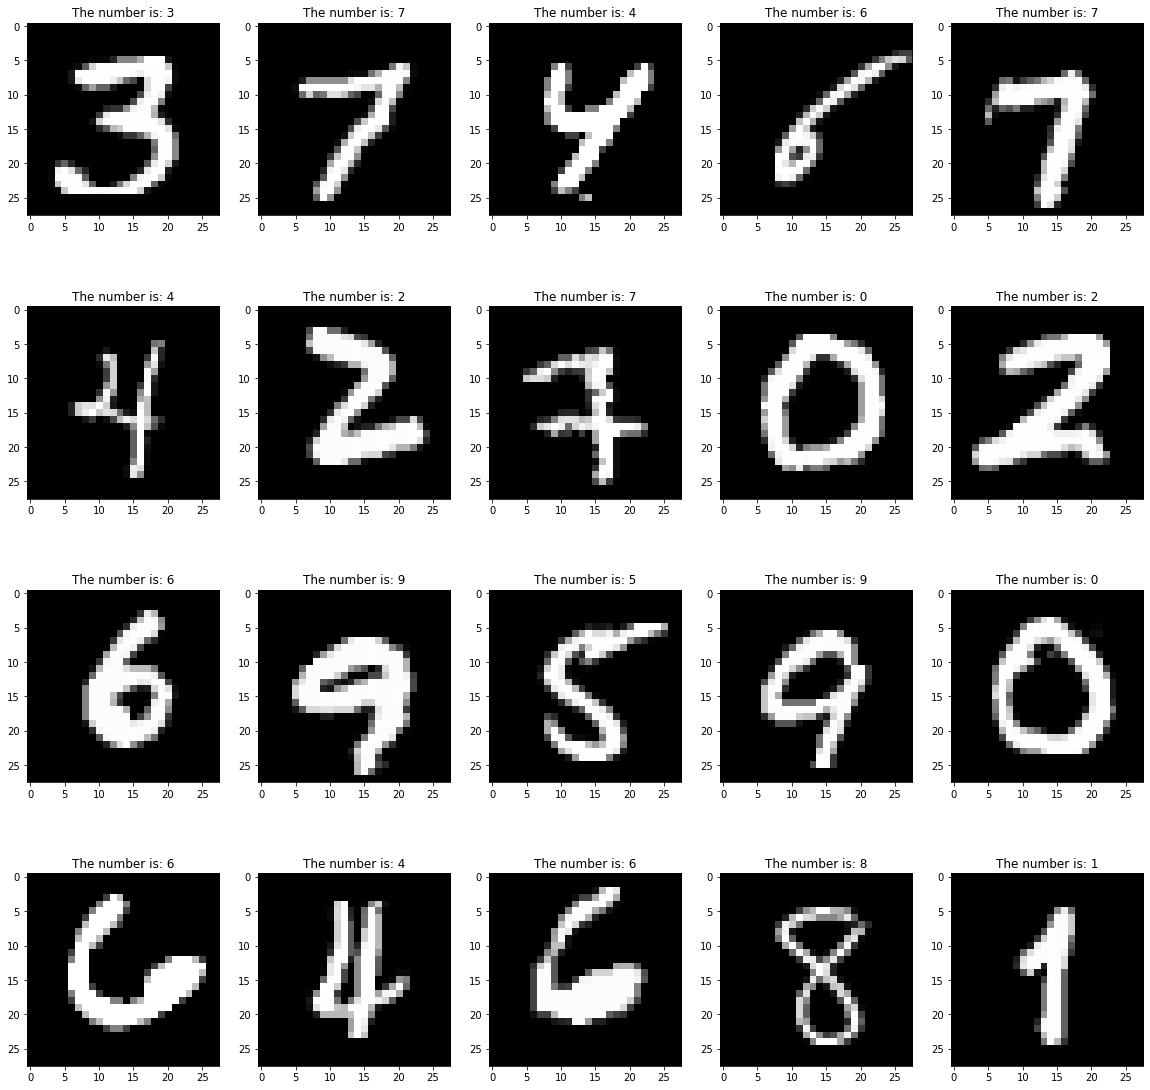

In [6]:
fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (20,20))
for i in range(4):
  for j in range(5):
    idx = np.random.randint(10000)
    ax[i][j].imshow(train_images[idx].reshape(28,28), cmap='gray')
    ax[i][j].set_title(f'The number is: {train_labels[idx]}')
plt.show()


Đưa ảnh về kích thước 28x28 và chuẩn hóa pixel của ảnh về khoảng (0,1)

In [7]:
# Phần này
X_train = train_images.reshape((train_images.shape[0], 28, 28, 1))
X_train = X_train.astype('float32') / 255

X_valid = val_images.reshape((val_images.shape[0], 28, 28, 1))
X_valid = X_valid.astype('float32') / 255

X_test = test_images.reshape((test_images.shape[0], 28, 28, 1))
X_test = X_test.astype('float32') / 255


Mã hóa phân loại nhãn về dạng one-hot vector

In [9]:
# One-hot vector của ta sẽ là một ma trận gồm 10 cột (tương ứng 1o giá trị của nhãn), và số hàng cùng số lượng giá trị
# Nhãn có giá trị thì ở dạng one-hot vector sẽ được đánh số 1 ở vị trí tương ứng, các vị trí khác trong hàng sẽ để đánh số 0
y_train = tf.keras.utils.to_categorical(train_labels)
y_valid = tf.keras.utils.to_categorical(val_labels)
y_test = tf.keras.utils.to_categorical(test_labels)

In [10]:
# Ta in ra kiểm tra xem số lượng dữ liệu có bị thay đổi sau quá trình chuẩn hóa không
print("Training Images:", X_train.shape)
print('Validation Images:', X_valid.shape)
print('-' * 10)
print("Testing Images:", X_test.shape)
print("Training Labels:", y_train.shape)
print('-' * 10)
print("Validation Images:", X_valid.shape)
print("Test Labels:", y_test.shape)

Training Images: (56000, 28, 28, 1)
Validation Images: (7000, 28, 28, 1)
----------
Testing Images: (7000, 28, 28, 1)
Training Labels: (56000, 10)
----------
Validation Images: (7000, 28, 28, 1)
Test Labels: (7000, 10)


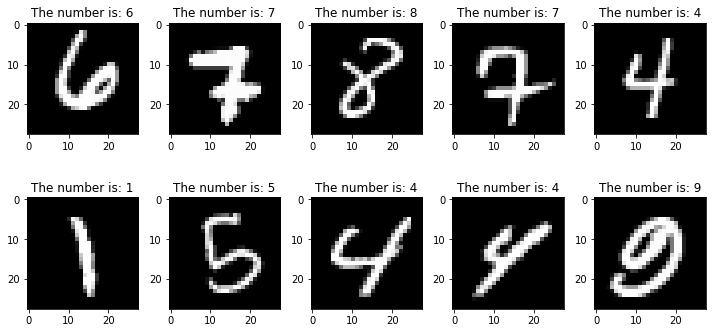

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,5))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(10000)
    ax[i][j].imshow(X_train[idx], cmap='gray')
    ax[i][j].set_title(f'The number is: {train_labels[idx]}')
plt.tight_layout()
plt.show()


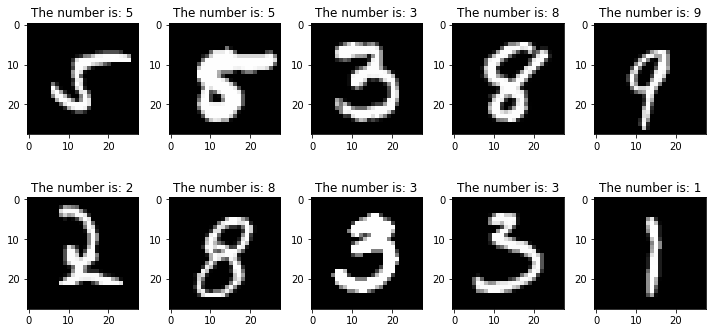

In [12]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,5))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(X_valid.shape[0])
    ax[i][j].imshow(X_valid[idx], cmap='gray')
    ax[i][j].set_title(f'The number is: {val_labels[idx]}')
plt.tight_layout()
plt.show()


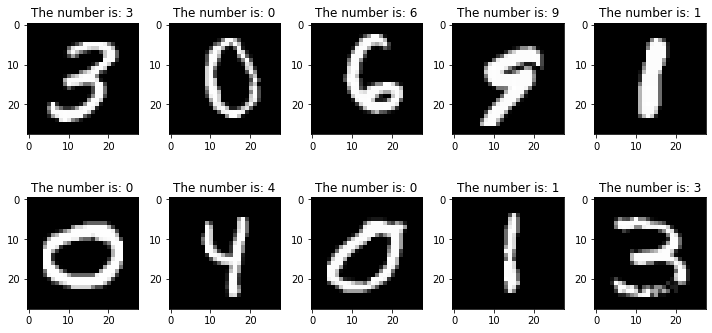

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,5))
for i in range(2):
  for j in range(5):
    idx = np.random.randint(X_test.shape[0])
    ax[i][j].imshow(X_test[idx], cmap='gray')
    ax[i][j].set_title(f'The number is: {test_labels[idx]}')
plt.tight_layout()
plt.show()


Lấy số chiều của ảnh và số lượng lớp

In [14]:
idx,width, height, channel = X_train[:0].shape
num_classes = len(y_train[0])

print('width, height, channel:',width, height, channel)
print('classes: ',num_classes)

width, height, channel: 28 28 1
classes:  10


## Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [39]:
X_train.shape, y_train.shape

((56000, 784), (56000,))

In [22]:
X_train = X_train.reshape(-1, 784)

In [23]:
X_train.shape

(56000, 784)

In [27]:
y_train = np.argmax(y_train, axis=1)

In [28]:
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB()

In [31]:
X_test = X_test.reshape(-1, 784)
y_pred = NB.predict(X_test)

In [40]:
y_test = np.argmax(y_test, axis=1)

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Gaussian Naive Bayes accuracy: {accuracy}")

Gaussian Naive Bayes accuracy: 0.5702857142857143
